In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import feature_extraction, linear_model, model_selection, naive_bayes, preprocessing, decomposition, metrics, tree 
import tensorflow as tf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import html
import re
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Activation, Dropout, SpatialDropout1D, LSTM, BatchNormalization, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
def print_mean_count(tokens:list, token_type:str):
    print(f"Mean # of {token_type}s per tweet: {np.round(np.mean(tokens),0)}")
    
def plot_tweet_token_distributions(tokens:list, token_type:str):
    print_mean_count(tokens, token_type)
    plt.hist([tokens], 50)
    plt.xlabel(f'Number of {token_type}s per tweet')
    plt.ylabel('Count')
    plt.title(f'{token_type} count distribution')
    plt.show()

# Disaster Tweets

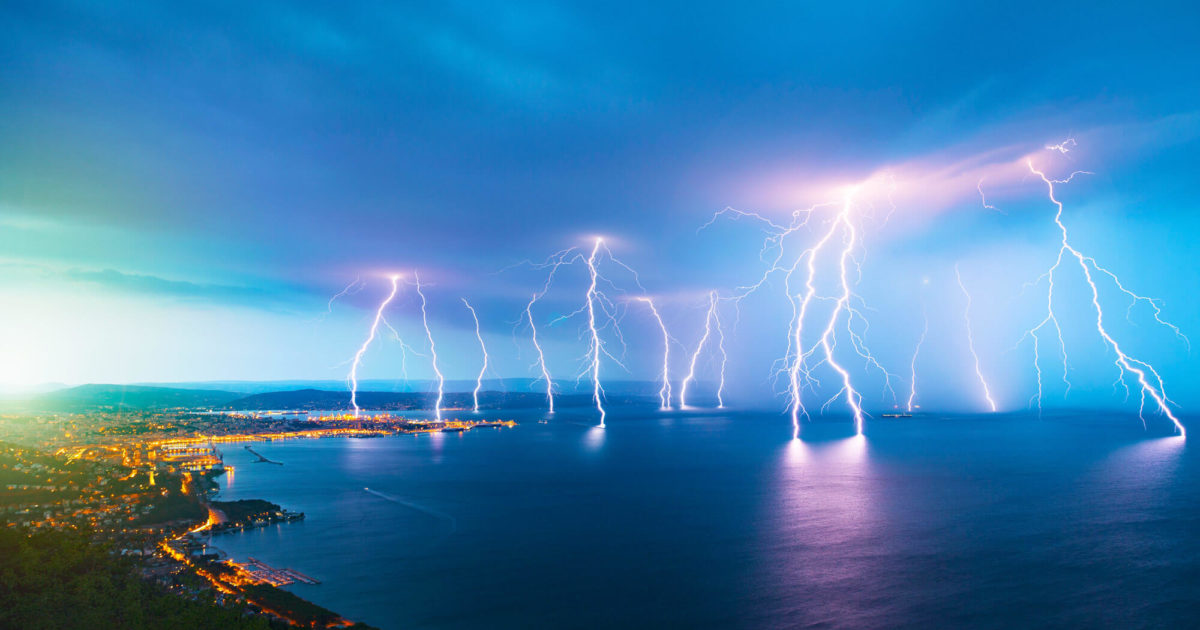

Social media allows anybody to broadcast whatever they want to the world. Looking at Twitter specifically, these message are littered with typos and slang and, as with all written text, intention is very difficult to convey, like sarcasm. The aim of this task is to train a predictor model to wade through messy tweets and determine which are referring to legitimate disasters (a storm, an earthquake) and which are not!

The given dataset contains the tweets, location and keyword data of the tweets and the target variable of 0 or 1 which denotes whether the tweet is describing a disaster or not. The metric for the classifier is the F1-score.


# 1. Dataset Analysis

The dataset currently contains tweets as they were sent by the user, warts and all, which means that there will be typos, slang, hashtags and handles and urls. A lot of this will not be useful for our models to learn and could affect performance but it will be important to dig into this raw data and understand where the usefulness lies.

## Training sample:

In [ ]:
filepath="../input/nlp-getting-started/"
train=pd.read_csv(f"{filepath}train.csv")
submission=pd.read_csv(f"{filepath}test.csv")

sample=train[pd.notnull(train["keyword"])].iloc[1,:]
print(sample)

## Dataset balance & missing values


The training set is quite __well balanced (57:43)__ between Disaster and Not-Disaster, though a slight skew to not-disaster may mean we need to balance it when training the model. 

Both the training and test set are missing values for __keyword__ and __location__, minimally in the case of keyword but a significant proportion of location. We will focus on the tweets for the moment and then possibly bring in these other features. 

In [ ]:
print("\nTraining set information:")
print("---------")
sns.countplot(x="target", data=train)
plt.show()
print("Proportion of samples with label 1 (ie A real disaster tweet):", np.round(train["target"].sum()/len(train)*100,2), "%")
print("Proportion of samples with label 0 (ie Not a real disaster tweet):", np.round((1-train["target"].sum()/len(train))*100,2),"%\n")

print("\nMissing Values:")
print(train.isna().sum())
print(f"\nNumber of samples: {train.shape[0]}")

print("\n\nTest set information:")
print("---------")
print("Missing values:")
print(submission.isna().sum())
print("\nNumber of samples:",submission.shape[0])

### Word & Character Counts

When we compare the disaster and not-disaster tweets, we see that the mean number of words does not change and the distributions are quite similar. When we compare characters we see that there is a much larger number of tweets with 130-140 characters that are talking about disasters. The not disaster tweet character count is more uniform with a lower spike around the same 130-140 range.

In [ ]:
def display_text_distribution(disaster, not_disaster, context):
    plt.hist([disaster], 50, color="#DB202C", alpha=1, label="Disaster")
    plt.hist([not_disaster], 50, color="#2D8ADB", alpha=0.7, label="Not Disaster")
    plt.xlabel(f'Number of {context}s per tweet')
    plt.ylabel('Count')
    plt.legend()
    plt.title(f'Disaster vs Not Disaster tweet {context} count')
    plt.show()

disaster_words=[len(s.split()) for s in train[train["target"]==1]["text"]]
not_disaster_words=[len(s.split()) for s in train[train["target"]==0]["text"]]

display_text_distribution(disaster_words,not_disaster_words,"word")

disaster_chars=[len(s) for s in train[train["target"]==1]["text"]]
not_disaster_chars=[len(s) for s in train[train["target"]==0]["text"]]

display_text_distribution(disaster_chars,not_disaster_chars,"char")

print_mean_count(disaster_words, "word")
print_mean_count(not_disaster_words, "word")
print_mean_count(disaster_chars, "character")
print_mean_count(not_disaster_chars, "character")

# 2. Data Cleaning

As the text in these samples are tweets, there may be twitter handles or hashtags that are nonsense, but some handles for example could be for an emergency service account which can help us in our prediction. There also may be links in a tweet, which will not be as helpful and we can remove. 

The function will 
* remove the @ and # of handles and hashtags
* set text to lowercase
* remove html characters
* convert apostrophe contractions to their full counterparts
* remove hyperlinks
* remove stopwords
* remove weird quirks from tweets such as "û_" and "vÌ_deo"

In [ ]:
stop_words = set(stopwords.words('english'))
wnl=WordNetLemmatizer()

stop_words.add("u")
Apos_dict={"'s":" is","won't":"will not", "can't":"cannot","n't":" not","'m":" am","'ll":" will",
           "'d":" would","'ve":" have","'re":" are"}

def clean_text(text: str)->str:
    text=text.lower()
    text=html.unescape(text) # remove html tag words
    for key,value in Apos_dict.items(): # remove contractions
        if key in text:
            text=text.replace(key,value)
    text=re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,4}\b", "", text) #emails
    text=re.sub(r"(?i)[0-ÿ]+_(?i)[0-ÿ]+", "", text)
    text=re.sub(r'https?:\/\/.\S+', "",text)    # remove links
    text=re.sub(r'\S*û_*\S*|@\w*|#\w*', "",text) # remove u_, handles and just the hashtag froms hashtags
    text=re.sub(r'[0-9]', "", text)
    text=re.sub(r'[^\w\s]', "",text)# remove any character not in the set [^] ie punctuation, can add # | @ here

    no_stopwords=[]
    for i in  WhitespaceTokenizer().tokenize(text):
        if i not in stop_words: no_stopwords.append(i)
    text=" ".join(no_stopwords)
    return text

print(f"An example\nThe uncleaned tweet: {train['text'].loc[71]}")
print(f"The cleaned tweet: {clean_text(train['text'].loc[71])}")

In [ ]:
cleaned_train=pd.DataFrame()
cleaned_train["text"]=train["text"].apply(clean_text)
cleaned_train["target"]=train["target"]

cleaned_test=pd.DataFrame()
cleaned_test["text"]=submission["text"].apply(clean_text)
print(cleaned_train)

## Cleaned Data Analysis

Here we will create wordclouds of the most common words for disaster and not-disaster tweets. It is promising that the disaster tweets include a lot of the words we would normally associate with disasters (fire, storm, flood, death, bomber, suicide) and the popular not-disaster tweets are much more benign. The other notable feature is the presence of some words in both wordclouds, and with quite predominant positions (new, one, via).

In [ ]:
twitter_mask = np.array(Image.open('../input/wordcloud-mask/twitter_mask.jpeg'))
def gen_word_cloud(tweets, label):
    wc = WordCloud(
        background_color='white', 
        max_words=200, 
        mask=twitter_mask,
    )
    wc.generate(' '.join(text for text in tweets))
    plt.figure(figsize=(18,10))
    plt.title(f'Top words for {label} Tweets', 
              fontdict={'size': 22,  'verticalalignment': 'bottom'})
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

gen_word_cloud(cleaned_train[cleaned_train["target"]==1]["text"], "Disaster")
gen_word_cloud(cleaned_train[cleaned_train["target"]==0]["text"], "Not-Disaster")

### Word & Character Counts

In [ ]:
disaster_words=[len(s.split()) for s in cleaned_train[cleaned_train["target"]==1]["text"]]
not_disaster_words=[len(s.split()) for s in cleaned_train[cleaned_train["target"]==0]["text"]]

plt.hist([disaster_words], 50, color="#DB202C", alpha=1, label="Disaster")
plt.hist([not_disaster_words], 50, color="#2D8ADB", alpha=0.7, label="Not-Disaster")
plt.xlabel(f'Number of words per tweet')
plt.ylabel('Count')
plt.legend()
plt.title(f'Disaster vs Not-Disaster tweet word count')
plt.show()

disaster_chars=[len(s) for s in cleaned_train[cleaned_train["target"]==1]["text"]]
not_disaster_chars=[len(s) for s in cleaned_train[cleaned_train["target"]==0]["text"]]

plt.hist([disaster_chars], 50, color="#DB202C", alpha=1, label="Disaster")
plt.hist([not_disaster_chars], 50, color="#2D8ADB", alpha=0.7, label="Not Disaster")
plt.xlabel(f'Number of characters per tweet')
plt.ylabel('Count')
plt.legend()
plt.title(f'Disaster vs Not-Disaster tweet character count')
plt.show()

display(pd.DataFrame({"Disaster":[np.round(np.mean(disaster_words),0),np.round(np.mean(disaster_chars),0)],
                      "Not-Disaster": [np.round(np.mean(not_disaster_words),0),np.round(np.mean(not_disaster_chars),0)]},
                     index=["mean # of words", "mean # of chars"]))

# 4(a) Bag-of-words + Multinomial Naive Bayes

To prepare the tweet data for the MultiNB model I have to vectorise the text so the model can interpret it. The approaches are known as __Bag-of-words__ models as they transform a text input into a vector of numbers that represents the words in the text input. 

The simplest way to do this is by counting the frequency of each word in the text, but this then inflates insignificant words, like 'the' or 'and'. The vectoriser I will use is __Term Frequency - Inverse Document Frequency__ or __TF-IDF__ which penalises words that are too frequent across all the documents but rates highly those that are rare but appear in lots of tweets.

### Data Vectorisation

In [ ]:
# Count or TF-IDF vectoriser
vectorisers={"count": feature_extraction.text.CountVectorizer(stop_words='english', 
                                                              analyzer="word",
                                                              ngram_range=(1,2),
                                                              max_features=None,
                                                              min_df=0.0004), 
             "tf_idf":feature_extraction.text.TfidfVectorizer(stop_words='english',
                                                              analyzer="word",
                                                              ngram_range=(1,2),
                                                              max_features=None,
                                                              min_df=0.0004)}
vec = vectorisers["tf_idf"]

In [ ]:
vec = vectorisers["tf_idf"]
x_train=np.array(cleaned_train["text"])
x_test=np.array(cleaned_test["text"])

vec=vec.fit(np.array(np.concatenate([x_train, x_test], axis=0)))
vectorised_train=vec.transform(np.array(cleaned_train["text"]))
vectorised_test=vec.transform(np.array(cleaned_test["text"]))

# LSA vectoriser - performed as second step to count or tf-idf
use_lsa=False
if use_lsa:
    lsa=decomposition.TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    vectorised_train=lsa.fit_transform(x_vec_train)

In [ ]:
print(f"Tweet: {cleaned_train['text'][5]}")
print(f"Vectorised tweet:\n{vectorised_train[5]}")

### Dataset Split

Now that the data has been cleaned and vectorised, it is time to train the predictor model. I will split the data into a training set to be used to train the model and a holdout set to evaluate the model on unseen data. The split we will use is the typical training 80%, holdout 20%.

In [ ]:
# Split data into training and test set
seed=datetime.now().time().microsecond

x_train, x_holdout, y_train, y_holdout = model_selection.train_test_split(vectorised_train, cleaned_train["target"], test_size=0.2, random_state=seed)

print("Training set features: ", x_train.shape)
print("Training set labels: ", y_train.shape)
print("Train Balance of dataset - labelled 1:", np.round(y_train.sum()/len(y_train),2)*100, "% labelled 0:", np.round(1-y_train.sum()/len(y_train),2)*100,"%")
#print(x_test)
#y_test=y_test.reset_index(drop=True)
print("Test set features: ", x_holdout.shape)
print("Test set labels: ", y_holdout.shape)
print("Test Balance of dataset - labelled 1:", np.round(y_holdout.sum()/len(y_holdout),2)*100, "% labelled 0:", np.round(1-y_holdout.sum()/len(y_holdout),2)*100,"%")

For a classic ML approach we will use __Multinomial Naive Bayes__ as it is a quick and efficient model which has a strong performance with text classification tasks.

### Training & Evaluation

We will use cross validation to test how the model performs with different training/validation sets of the data and use F1 as the scoring parameter.

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.svm import LinearSVC

def get_word_importances(clf):
    #print(vec.vocabulary_)
    coefs=np.array(clf.coef_[0])
    word_imps=pd.DataFrame({"word":list(vec.vocabulary_.keys()), 
                  "vocab index":list(vec.vocabulary_.values()), 
                  "importance":coefs})
    word_imps=word_imps.sort_values("importance", ascending=False)

    print(word_imps.iloc[0:10])

# classical machine learning models
models = {"LogisticRegression":{'model':linear_model.LogisticRegression(solver="liblinear", penalty="l2"), 'params':{}},
          "SVM": {'model': LinearSVC(), 'params': {}},
          "NaiveBayes":{'model':naive_bayes.MultinomialNB(), "params": {}}}


focus="NaiveBayes"
clf=models[focus]["model"].set_params(**models[focus]["params"])

print(f"{clf}\n--------")

scores = model_selection.cross_val_score(clf, x_train, y_train, cv=3, scoring="f1")
clf.fit(x_train, y_train)

print(f"Cross val (f1): {scores.mean()}")
print(f"Holdout Accuracy: {clf.score(x_holdout, y_holdout)}")
print(f"f1-score (Holdout): {metrics.f1_score(y_holdout, clf.predict(x_holdout))}\n")

metrics.plot_confusion_matrix(clf, x_holdout, y_holdout)
plt.show()
get_word_importances(clf)

if focus=="SVM":
    class_prob=clf.decision_function(x_holdout)
else:
    class_prob=clf.predict_proba(x_holdout)[:,1]

precision, recall, thresholds = precision_recall_curve(y_holdout, class_prob)
PrecisionRecallDisplay(precision=precision, recall=recall).plot(name=clf)

fpr, tpr, _ = roc_curve(y_holdout, class_prob)
RocCurveDisplay(fpr=fpr,tpr=tpr).plot(name=clf)
print(f"AUC value for {clf} is {roc_auc_score(y_holdout, class_prob)}")

We get a __holdout prediction accuracy of ~80%__ and an __AUC score of ~86%__.

### Tuning Hyperparameters

The next step here is to tune the hyperparamters of the naive bayes model and use the tuned model to prediction the given competition test set.

In [ ]:
from sklearn import pipeline

param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'fit_prior' : [True, False],
             'class_prior' : [None, [.5,.5],[.4, .6]]}

model = model_selection.GridSearchCV(estimator=clf, param_grid=param_grid, scoring="f1",
                                 verbose=1, n_jobs=-1, refit=True, cv=5)

model.fit(x_train, y_train)
params=model.best_params_
print(f"Best Parameters: {params}")
models[focus]["params"]=params

## Submission

This model achieves a __score of 0.79681__.

In [ ]:
submission["target"] = clf.predict(vectorised_test)
submission.head()
submission[["id", "target"]].to_csv("submission.csv", index=False)

---

# 3(b) Glove Embeddings + Deep Learning

The BoWs model to train a classic machine learning model is useful to get a quick understanding of the performance levels you can achieve on the task using a more simple model.

A downside to that approach, however, is that the model takes each token in the tweet without drawing any context, like their order in a sentence or that some different tokens may have similar meanings.

## Simple vectors + GloVe

Glove is a collection of pretrained word embeddings that groups various words depending on their semantic similarity, (see https://nlp.stanford.edu/projects/glove/) The glove embeddings for the tokens in our vocabulary will be used as __weights__ of the neural network __embedding layer__.

The tweets will be vectorised with simple integer vectors, padded so they are all the same length (same as the longest input) and where each index corresponds to their order and each value corresponds to a particular token that is at that index in the weights.

If a token does not have a corresponding embedding then its vector is set to 0.

<!-- keep following this:https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/ -->

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
cleaned_test["text"]=submission["text"].apply(clean_text)
cleaned_train=pd.DataFrame()
cleaned_train["text"]=train["text"].apply(clean_text)
cleaned_train["target"]=train["target"]

tweets=pd.concat((cleaned_train["text"],cleaned_test["text"]),axis=0).reset_index(drop="True")

t = Tokenizer()
t.fit_on_texts(tweets)

embeddings_index=dict()
with open('../input/glove6b/glove.6B.100d.txt') as f:
    for line in f:
        values=line.split()
        word=values[0]
        if word in t.word_index.keys():
            coefs=np.asarray(values[1:], dtype="float32")
            embeddings_index[word]=coefs

problem_words=list()
for word in t.word_index.keys():
    if word not in embeddings_index.keys():
        problem_words.append(word)
        
vocab_size = len(t.word_index)+1

longest_tweet = max(tweets, key=lambda sentence: len(word_tokenize(sentence)))
tokens_in_longest_tweet = len(word_tokenize(longest_tweet))

print(f"tokens in vocabulary: {len(t.word_index.items())}")
print(f"tokens with embeddings: {len(embeddings_index)}")
print(f"tokens with no embeddings: {len(problem_words)}")
print(f"The longest tweet is {tokens_in_longest_tweet} tokens long\n")


index_vectors = pad_sequences(
    t.texts_to_sequences(cleaned_train["text"]), 
    tokens_in_longest_tweet, 
    padding='post'
)

test_index_vectors = pad_sequences(
    t.texts_to_sequences(cleaned_test["text"]), 
    tokens_in_longest_tweet, 
    padding='post'
)

print(f"Index vectors:\n{index_vectors}\nIndex Vectors Shape: {index_vectors.shape}\n")

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Embedding Matrix:\n{embedding_matrix}\nEmbedding Matrix Shape: {embedding_matrix.shape}")

## Training

In [ ]:
rnn_nodes=64
model = keras.Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=tokens_in_longest_tweet, trainable=False))

model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(units=rnn_nodes, activation="relu", kernel_regularizer='l2', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(units=rnn_nodes, activation="relu", kernel_regularizer='l2', dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))
  
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
seed=datetime.now().time().microsecond
x_train, x_holdout, y_train, y_holdout = model_selection.train_test_split(index_vectors, cleaned_train["target"], test_size=0.2, random_state=seed)

In [ ]:
epochs=10
batch_size = 32

model.summary()
history = model.fit(x_train, y=y_train, batch_size=batch_size, 
      epochs=epochs, verbose=1, validation_split=0.2, validation_freq=1,shuffle=1, workers=4)

## Evaluation

In [ ]:
def plot_model(history):
    acc = history['acc'] if 'acc' in history.keys() else history['accuracy']
    val_acc = history['val_acc'] if 'val_acc' in history.keys() else history['val_accuracy']
    loss = history['loss'] 
    val_loss = history['val_loss'] 
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
plot_model(history.history)

In [ ]:
from sklearn.metrics import accuracy_score

pred=model.predict(x_holdout)
pred=np.apply_along_axis(lambda x: 0 if x[0]<0.5 else 1, 1, pred)
print(f"Accuracy on holdout set: {accuracy_score(y_holdout, pred)}\n")

precision, recall, thresholds=metrics.precision_recall_curve(y_holdout, pred)
fpr, tpr, thresholds=metrics.roc_curve(y_holdout, pred)

threshold=0.5
for i in range(len(pred)):
    if pred[i]>threshold: pred[i]=1
    else: pred[i]=0

cm=metrics.confusion_matrix(y_holdout, pred)
disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
print("Confusion Matrix for DL model")
disp.plot()
print(f"For threshold level: {threshold}")
    
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for DL model")
plt.legend(loc="lower right")
plt.show()

## Submission

This model achieves a __score of 0.79221__

We can get a better score than this, we will keep digging!

In [ ]:
model.fit(x_holdout, y=y_holdout, batch_size=batch_size, 
      epochs=epochs, verbose=1, validation_split=0.2, validation_freq=1,shuffle=1, workers=4)

submission["target"] = model.predict(test_index_vectors)
submission["target"]=submission["target"].apply(lambda x: 0 if x<0.5 else 1)
print(submission.head())
submission[["id", "target"]].to_csv("embeddings_submission.csv", index=False)

## Further Analysis

* Tune LSTM model
* Incorporate other features
* BERT